In [6]:
# Imports


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
# import SVC
from sklearn.svm import SVC

import math
import seaborn as sns
import warnings                   # To ignore the warnings
import pandas as pd
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

%matplotlib inline
warnings.filterwarnings("ignore")


In [2]:
# Data extraction

train = pd.read_csv("../data/train.csv")
valid = pd.read_csv("../data/valid.csv")


In [3]:
train.describe()


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,label_1,label_2,label_3,label_4
count,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,...,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28040.000000,28520.000000,28520.000000
mean,-0.225478,-0.616421,-0.212878,0.336330,0.105467,-0.339634,-0.201756,0.742262,0.942325,-1.957584,...,-0.028098,0.296340,1.724439,-1.476765,0.687445,-1.563062,30.498843,27.975107,0.799299,5.997125
std,0.990632,1.005573,1.075468,1.248919,0.831132,1.073267,0.943505,1.055721,0.940459,0.876939,...,0.989497,1.173378,0.968611,1.032811,1.028328,1.243758,17.328389,5.735913,0.400532,2.375567
min,-4.023911,-5.582544,-4.679888,-4.284380,-3.010300,-5.034355,-4.355222,-3.806574,-2.922614,-5.203347,...,-3.679602,-3.905801,-3.301683,-5.490267,-3.810144,-6.056032,1.000000,22.000000,0.000000,0.000000
25%,-0.869656,-1.287018,-0.913419,-0.478661,-0.437171,-1.075753,-0.823699,0.064072,0.298269,-2.556436,...,-0.692262,-0.550897,1.121631,-2.130906,-0.008394,-2.404028,15.000000,25.000000,1.000000,6.000000
50%,-0.190790,-0.609782,-0.218800,0.295881,0.117310,-0.329571,-0.193263,0.755193,0.940786,-1.949847,...,-0.018218,0.295523,1.783432,-1.449978,0.639575,-1.650610,30.000000,27.000000,1.000000,6.000000
75%,0.457509,0.063174,0.490262,1.119242,0.657941,0.393339,0.417146,1.461846,1.579200,-1.345999,...,0.644112,1.128566,2.383575,-0.799414,1.347263,-0.805710,46.000000,30.000000,1.000000,6.000000
max,4.322171,3.876604,4.267163,5.828656,3.884939,3.890622,3.799406,4.817545,4.615069,1.147192,...,3.915582,4.458014,5.261775,2.861117,5.531152,3.338544,60.000000,61.000000,1.000000,13.000000


In [3]:
# Extracting x and y

x_train = train.copy().drop(
    columns=["label_1", "label_2", "label_3", "label_4"])
x_valid = valid.copy().drop(
    columns=["label_1", "label_2", "label_3", "label_4"])
x_feature_names = ["feature_" + str(i) for i in range(1, 257)]

iD_train = train["label_1"].to_frame()
age_train = train["label_2"].to_frame()  # Age has NaN
gender_train = train["label_3"].to_frame()
accent_train = train["label_4"].to_frame()  # Accent has bias to 6

iD_valid = valid["label_1"].to_frame()
age_valid = valid["label_2"].to_frame()
gender_valid = valid["label_3"].to_frame()
accent_valid = valid["label_4"].to_frame()


In [5]:
# Print the unique values of each column in iD_valid and the count of unique values
for col in iD_train.columns:
    print(col, iD_train[col].nunique(), (iD_train[col].nunique() / 28520) * 100)

for col in age_train.columns:
    print(col, age_train[col].nunique(), (age_train[col].nunique() / 28520) * 100)

for col in gender_train.columns:
    print(col, gender_train[col].nunique(), (gender_train[col].nunique() / 28520) * 100)

for col in accent_train.columns:
    print(col, accent_train[col].nunique(), (accent_train[col].nunique() / 28520) * 100)

# Therefore all can be considered as categorical variables as low percentage
# ID is not useful and age can be a continuous variable
# Therefore, age is considered as a continuous variable

label_1 60 0.21037868162692847
label_2 17 0.05960729312762973
label_3 2 0.007012622720897616
label_4 14 0.049088359046283316


In [7]:
# Scaling Features

scaler_standard = StandardScaler()
scaler_standard.fit(x_train)

x_train_scaled_standard = pd.DataFrame(
    scaler_standard.transform(x_train), columns=x_feature_names
)
x_valid_scaled_standard = pd.DataFrame(
    scaler_standard.transform(x_valid), columns=x_feature_names
)

# Scaling using RobustScaler
scaler_robust = RobustScaler()
scaler_robust.fit(x_train)

x_train_scaled = pd.DataFrame(scaler_robust.transform(x_train), columns=x_feature_names)
x_valid_scaled = pd.DataFrame(scaler_robust.transform(x_valid), columns=x_feature_names)

## For Age as Continuous

Age is continuous -> Use a regressor -> Using linear regression


<Axes: >

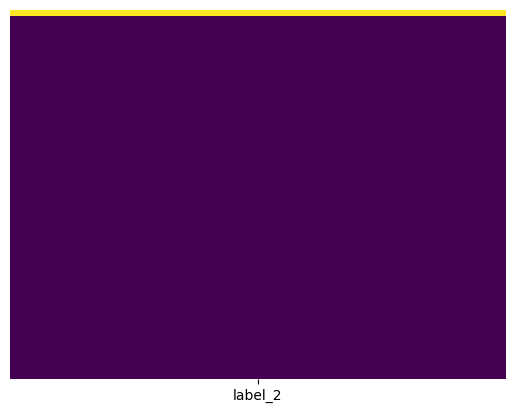

In [7]:
# Get heatmap for null values in age_train
sns.heatmap(age_train.isnull(), yticklabels=False, cbar=False, cmap="viridis")

# get the number of zeroes in age valid
# age_train[age_train['label_2'].isnull()].shape

In [8]:
# Handling NaN values in the age
# Combine X and y into a single DataFrame
data = pd.concat([x_train, age_train], axis=1)

# Remove rows with null values
data_cleaned = data.dropna()

# Separate X and y again
x_train_null_removed_from_age = data_cleaned.drop(columns=["label_2"])
age_train_null_removed = data_cleaned["label_2"]

# For validation set
# Combine X and y into a single DataFrame
data_valid = pd.concat([x_valid, age_valid], axis=1)

# Remove rows with null values
data_cleaned_valid = data_valid.dropna()

# Separate X and y again
x_valid_null_removed_from_age = data_cleaned_valid.drop(columns=["label_2"])
age_valid_null_removed = data_cleaned_valid["label_2"].to_frame()

In [9]:
# Without Any preprocessing

# Create a Linear Regression model
regression_model = LinearRegression()

# Train the model on the training data
regression_model.fit(x_train_null_removed_from_age, age_train_null_removed)

# Make predictions on the test data
y_pred_initial = regression_model.predict(x_valid_null_removed_from_age)

# Calculate the Mean Squared Error (MSE) to evaluate the model's performance
mse_initial = mean_squared_error(age_valid_null_removed, y_pred_initial)

print("Root Mean Squared Error for linearRegression:", math.sqrt(mse_initial))


Root Mean Squared Error for linearRegression: 4.881146590751572


### Using Feature Normalisation


In [10]:
age_valid_null_removed_values[:10]


NameError: name 'age_valid_null_removed_values' is not defined

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(x_train_null_removed_from_age)
X_valid_normalized = scaler.transform(x_valid_null_removed_from_age)

# You can also normalize the target variable "age" separately
age_train_null_removed_values = age_train_null_removed.values.reshape(
    -1, 1
)  # Reshape y to a column vector
age_train_normalized = scaler.fit_transform(age_train_null_removed_values)

age_valid_null_removed_values = age_valid_null_removed.values.reshape(
    -1, 1
)  # Reshape y to a column vector
age_valid_normalized = scaler.transform(age_valid_null_removed_values)

In [ ]:
# Create a Linear Regression model
regression_model_scaled_data = LinearRegression()

# Train the model on the training data
regression_model_scaled_data.fit(
    X_train_normalized, age_train_null_removed_values)

# Make predictions on the test data
y_pred_initial_scaled = regression_model_scaled_data.predict(
    X_valid_normalized)


In [ ]:
mse_scaled = mean_squared_error(
    age_valid_null_removed_values, y_pred_initial_scaled.reshape(-1, 1)
)

print("Root Mean Squared Error for linearRegression:", math.sqrt(mse_scaled))

Root Mean Squared Error for linearRegression: 4.881146590751575


### Feature correlation


In [ ]:
correlation_matrix = x_train_null_removed_from_age.corr()

In [ ]:
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
correlation_threshold = 0.67
# Find highly correlated features
highly_correlated = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated.add(colname_i)
            highly_correlated.add(colname_j)


In [ ]:
highly_correlated


{'feature_233', 'feature_36'}

In [ ]:
# Remove highly correlated features from X_train
X_train_correlation = x_train_null_removed_from_age.copy()
X_train_filtered = X_train_correlation.drop(columns=highly_correlated)
X_valid_filtered = x_valid_null_removed_from_age.copy().drop(
    columns=highly_correlated)


In [ ]:
# Create a Linear Regression model
regression_model_correlation = LinearRegression()

# Train the model on the training data
regression_model_correlation.fit(
    X_train_filtered, age_train_null_removed_values)

# Make predictions on the test data
y_pred_initial_correlation = regression_model_correlation.predict(
    X_valid_filtered)


In [ ]:
mse_corr = mean_squared_error(
    age_valid_null_removed_values, y_pred_initial_correlation.reshape(-1, 1)
)

print("Root Mean Squared Error for correlation:", math.sqrt(mse_corr))

Root Mean Squared Error for correlation: 4.8794564852379985


### Using PCA


In [ ]:
scaler_pca = StandardScaler()
X_train_normalized_pca = scaler_pca.fit_transform(X_train_filtered)
X_valid_normalized_pca = scaler_pca.transform(X_valid_filtered)

# You can also normalize the target variable "age" separately
# age_train_null_removed_values = age_train_null_removed.values.reshape(-1, 1)  # Reshape y to a column vector
# age_train_normalized = scaler.fit_transform(age_train_null_removed_values)

# age_valid_null_removed_values = age_valid_null_removed.values.reshape(-1, 1)  # Reshape y to a column vector
# age_valid_normalized = scaler.transform(age_valid_null_removed_values)

In [ ]:
pca = PCA(n_components=100)

pca.fit(X_train_normalized_pca)

X_train_pca = pca.transform(X_train_normalized_pca)
X_valid_pca = pca.transform(X_valid_normalized_pca)

In [ ]:
X_train_pca.shape


(28040, 100)

In [ ]:
# Create a Linear Regression model
regression_model_pca = LinearRegression()


# Train the model on the training data
regression_model_pca.fit(X_train_pca, age_train_null_removed_values)

# Make predictions on the test data
y_pred_initial_pca = regression_model_pca.predict(X_valid_pca)

mse_pca = mean_squared_error(
    age_valid_null_removed_values, y_pred_initial_pca.reshape(-1, 1)
)

print("Root Mean Squared Error for correlation:", math.sqrt(mse_pca))

Root Mean Squared Error for correlation: 5.33437125520369


In [ ]:
# Print the explained variance ratios of each component
explained_variance_ratios = lda.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance_ratios)


Explained Variance Ratios: [0.16065666 0.12074922 0.09290212 0.08556048 0.07747794 0.06062247
 0.05763222 0.05327585 0.04801955 0.04686548 0.03985627 0.03711658
 0.0353982  0.03391201 0.02752475 0.0224302 ]


# For Age as Categorical


In [8]:
# Handling NaN values in the age
# Combine X and y into a single DataFrame
from sklearn.preprocessing import LabelEncoder

age_data_train_cat = pd.concat([x_train_scaled, age_train], axis=1)
age_data_valid_cat = pd.concat([x_valid_scaled, age_valid], axis=1)

# Remove rows with null values
age_data_cleaned_train_cat = age_data_train_cat.dropna()
age_data_cleaned_valid_cat = age_data_valid_cat.dropna()

# Separate X and y again
age_x_train_cat = age_data_cleaned_train_cat.drop(columns=["label_2"])
age_y_train_cat = age_data_cleaned_train_cat["label_2"]
age_x_valid_cat = age_data_cleaned_valid_cat.drop(columns=["label_2"])
age_y_valid_cat = age_data_cleaned_valid_cat["label_2"].to_frame()

# encode age_y_train_cat as categorical

label_encoder = LabelEncoder()
age_y_train_cat_encoded = label_encoder.fit_transform(age_y_train_cat)
age_y_valid_cat_encoded = label_encoder.transform(age_y_valid_cat)

## Initial


In [9]:
# Train a SVC on non-engineered Data

rf_model_initial = SVC()
rf_model_initial.fit(age_x_train_cat, age_y_train_cat_encoded)

SVC()

accuracy_score_rf_initial:  0.9850543478260869
Precision, Recall and F1 Score: (0.9888894610381574, 0.9829899743770372, 0.9856505492377918, None)


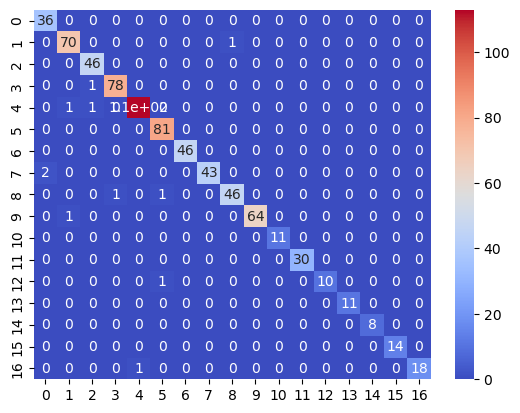

In [10]:
# Make predictions on the test data
y_pred_rf_initial = rf_model_initial.predict(age_x_valid_cat)

# get accuracy score
accuracy_score_rf_initial = accuracy_score(age_y_valid_cat_encoded, y_pred_rf_initial)
print("accuracy_score_rf_initial: ", accuracy_score_rf_initial)

# Get confusion matrix
confusion_matrix_rf_initial = confusion_matrix(
    age_y_valid_cat_encoded, y_pred_rf_initial
)

# plot confusion matrix
sns.heatmap(confusion_matrix_rf_initial, annot=True, cmap="coolwarm")

# get precision, recall and f1 score
precision_recall_fscore_rf_initial = precision_recall_fscore_support(
    age_y_valid_cat_encoded, y_pred_rf_initial, average="macro"
)
print("Precision, Recall and F1 Score:", precision_recall_fscore_rf_initial)

## Outlier removal


In [ ]:
# find the count of each class in the training data
age_y_train_cat.value_counts()


26.0    4762
25.0    2849
27.0    2846
23.0    2842
31.0    2385
24.0    1906
28.0    1899
30.0    1894
22.0    1432
29.0    1424
33.0     945
36.0     481
35.0     480
34.0     478
32.0     476
41.0     474
61.0     467
Name: label_2, dtype: int64

61.0

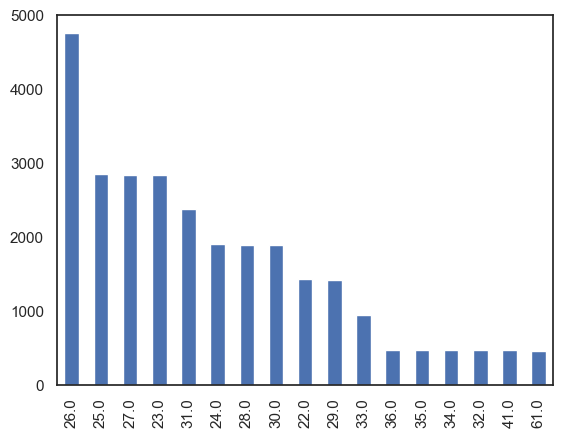

In [ ]:
# Find the distribution of the classes in the training data
age_y_train_cat.value_counts().plot(kind="bar")

# Classes are not equally distributed

In [ ]:
# Remove the outliers from the training data
age_data_cleaned_train_cat_outliers_removed = age_data_cleaned_train_cat[
    age_data_cleaned_train_cat["label_2"] < 60
]
# Add 1 datapoint with outlier to the train data
age_data_cleaned_train_cat_outliers_removed = (
    age_data_cleaned_train_cat_outliers_removed.append(
        age_data_cleaned_train_cat[age_data_cleaned_train_cat["label_2"] > 60].iloc[0]
    )
)

# Separate X and y again
age_x_train_cat_outliers_removed = age_data_cleaned_train_cat_outliers_removed.drop(
    columns=["label_2"]
)
age_y_train_cat_outliers_removed = age_data_cleaned_train_cat_outliers_removed[
    "label_2"
]


# encode age_y_train_cat_outliers_removed
age_y_train_cat_outliers_removed_encoded = label_encoder.transform(
    age_y_train_cat_outliers_removed
)


In [ ]:
age_data_cleaned_train_cat_outliers_removed[
    age_data_cleaned_train_cat_outliers_removed["label_2"] > 60
]


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,label_2
7615,-2.406735,-1.303055,0.922239,-1.340975,-0.06748,-0.452519,-0.762652,0.909375,0.540315,0.034832,...,-1.475258,1.236942,2.246203,-1.907627,0.831809,0.592875,-1.22565,0.273602,0.722032,61.0


In [ ]:
age_y_train_cat_outliers_removed_encoded[:5]

array([3, 3, 3, 3, 3], dtype=int64)

In [ ]:
# Train a random forest classifier for the data without outliers

rf_model_outliers_removed = RandomForestClassifier(n_estimators=25)
rf_model_outliers_removed.fit(
    age_x_train_cat_outliers_removed, age_y_train_cat_outliers_removed_encoded
)


RandomForestClassifier()

accuracy_score_rf_outliers_removed:  0.8994565217391305
Precision, Recall and F1 Score: (0.8953134226783189, 0.8638390869445135, 0.8772652298808916, None)


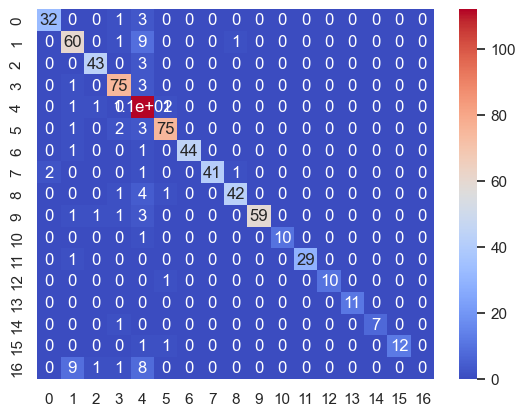

In [ ]:
# Make predictions on the test data
y_pred_rf_outliers_removed = rf_model_outliers_removed.predict(age_x_valid_cat)

# get accuracy score
accuracy_score_rf_outliers_removed = accuracy_score(
    age_y_valid_cat_encoded, y_pred_rf_outliers_removed
)
print("accuracy_score_rf_outliers_removed: ",
      accuracy_score_rf_outliers_removed)
# Get confusion matrix
confusion_matrix_rf_outliers_removed = confusion_matrix(
    age_y_valid_cat_encoded, y_pred_rf_outliers_removed
)

# plot confusion matrix
sns.heatmap(confusion_matrix_rf_outliers_removed, annot=True, cmap="coolwarm")

# get precision, recall and f1 score
precision_recall_fscore_rf_outliers_removed = precision_recall_fscore_support(
    age_y_valid_cat_encoded, y_pred_rf_outliers_removed, average="macro"
)
print("Precision, Recall and F1 Score:",
      precision_recall_fscore_rf_outliers_removed)


## PCA


In [17]:
# PCA for Age data

pca_cat = PCA(n_components=50)

pca_cat.fit(age_x_train_cat)

age_x_train_pca = pd.DataFrame(
    pca_cat.transform(age_x_train_cat),
    columns=["feature_pca_" + str(i) for i in range(1, 51)],
)
age_x_valid_pca = pd.DataFrame(
    pca_cat.transform(age_x_valid_cat),
    columns=["feature_pca_" + str(i) for i in range(1, 51)],
)

# with 50 features
pca_cat_50 = PCA(n_components=50)

pca_cat_50.fit(age_x_train_cat)

age_x_train_pca_50 = pd.DataFrame(
    pca_cat_50.transform(age_x_train_cat),
    columns=["feature_pca_" + str(i) for i in range(1, 51)],
)
age_x_valid_pca_50 = pd.DataFrame(
    pca_cat_50.transform(age_x_valid_cat),
    columns=["feature_pca_" + str(i) for i in range(1, 51)],
)

# with 90
pca_cat_90 = PCA(n_components=90, svd_solver="full")

pca_cat_90.fit(age_x_train_cat)
n_components = pca_cat_90.n_components


age_x_train_pca_90 = pd.DataFrame(
    pca_cat_90.transform(age_x_train_cat),
    columns=["feature_pca_" + str(i) for i in range(1, n_components + 1)],
)
age_x_valid_pca_90 = pd.DataFrame(
    pca_cat_90.transform(age_x_valid_cat),
    columns=["feature_pca_" + str(i) for i in range(1, n_components + 1)],
)

# with 95
pca_cat_95 = PCA(n_components=0.95, svd_solver="full")

pca_cat_95.fit(age_x_train_cat)
n_components_95 = pca_cat_95.components_.shape[0]


age_x_train_pca_95 = pd.DataFrame(
    pca_cat_95.transform(age_x_train_cat),
    columns=["feature_pca_" + str(i) for i in range(1, n_components_95 + 1)],
)
age_x_valid_pca_95 = pd.DataFrame(
    pca_cat_95.transform(age_x_valid_cat),
    columns=["feature_pca_" + str(i) for i in range(1, n_components_95 + 1)],
)


In [18]:
print("n_components pca ", n_components)
print("n_components pca 95 ", n_components_95)

n_components pca  90
n_components pca 95  67


In [19]:
# Train a Random forest

rf_model_pca = SVC()
rf_model_pca.fit(age_x_train_pca, age_y_train_cat_encoded)

SVC()

accuracy_score_rf_pca:  0.9728260869565217
Precision, Recall and F1 Score: (0.9777095943946482, 0.9723259638082848, 0.9743968925359681, None)


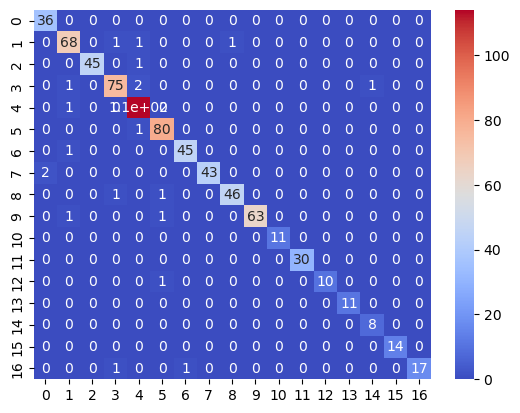

In [20]:
# Make predictions on the test data - pca - 100
y_pred_rf_pca = rf_model_pca.predict(age_x_valid_pca)

# get accuracy score
accuracy_score_rf_pca = accuracy_score(age_y_valid_cat_encoded, y_pred_rf_pca)
print("accuracy_score_rf_pca: ", accuracy_score_rf_pca)
# Get confusion matrix
confusion_matrix_rf_pca = confusion_matrix(
    age_y_valid_cat_encoded, y_pred_rf_pca)

# plot confusion matrix
sns.heatmap(confusion_matrix_rf_pca, annot=True, cmap="coolwarm")

# get precision, recall and f1 score
precision_recall_fscore_rf_pca = precision_recall_fscore_support(
    age_y_valid_cat_encoded, y_pred_rf_pca, average="macro"
)
print("Precision, Recall and F1 Score:", precision_recall_fscore_rf_pca)


In [21]:
# Train a Random forest

rf_model_pca_50 = SVC()
rf_model_pca_50.fit(age_x_train_pca_50, age_y_train_cat_encoded)

SVC()

accuracy_score_rf_pca_50_50:  0.9728260869565217
Precision, Recall and F1 Score: (0.9785363260108236, 0.9718472746800513, 0.9744960125132138, None)


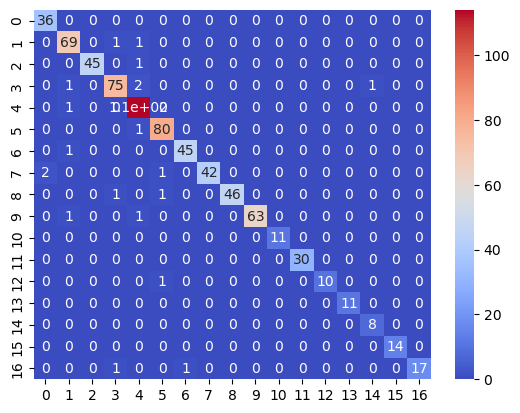

In [22]:
# Make predictions on the test data - pca 50
y_pred_rf_pca_50 = rf_model_pca_50.predict(age_x_valid_pca_50)

# get accuracy score
accuracy_score_rf_pca_50 = accuracy_score(
    age_y_valid_cat_encoded, y_pred_rf_pca_50)
print("accuracy_score_rf_pca_50_50: ", accuracy_score_rf_pca_50)
# Get confusion matrix
confusion_matrix_rf_pca_50 = confusion_matrix(
    age_y_valid_cat_encoded, y_pred_rf_pca_50)

# plot confusion matrix
sns.heatmap(confusion_matrix_rf_pca_50, annot=True, cmap="coolwarm")

# get precision, recall and f1 score
precision_recall_fscore_rf_pca_50 = precision_recall_fscore_support(
    age_y_valid_cat_encoded, y_pred_rf_pca_50, average="macro"
)
print("Precision, Recall and F1 Score:", precision_recall_fscore_rf_pca_50)


In [23]:
# Train a Random forest

rf_model_pca_90 = SVC()
rf_model_pca_90.fit(age_x_train_pca_90, age_y_train_cat_encoded)

SVC()

accuracy_score_rf_pca_90_90:  0.9836956521739131
Precision, Recall and F1 Score: (0.9883728928325293, 0.9822453727389137, 0.985018730409952, None)


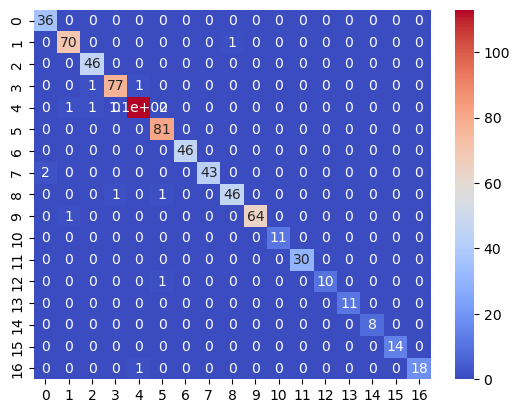

In [24]:
# Make predictions on the test data - pca 90
y_pred_rf_pca_90 = rf_model_pca_90.predict(age_x_valid_pca_90)

# get accuracy score
accuracy_score_rf_pca_90 = accuracy_score(
    age_y_valid_cat_encoded, y_pred_rf_pca_90)
print("accuracy_score_rf_pca_90_90: ", accuracy_score_rf_pca_90)
# Get confusion matrix
confusion_matrix_rf_pca_90 = confusion_matrix(
    age_y_valid_cat_encoded, y_pred_rf_pca_90)

# plot confusion matrix
sns.heatmap(confusion_matrix_rf_pca_90, annot=True, cmap="coolwarm")

# get precision, recall and f1 score
precision_recall_fscore_rf_pca_90 = precision_recall_fscore_support(
    age_y_valid_cat_encoded, y_pred_rf_pca_90, average="macro"
)
print("Precision, Recall and F1 Score:", precision_recall_fscore_rf_pca_90)


In [25]:
# Train a Random forest

rf_model_pca_95 = SVC()
rf_model_pca_95.fit(age_x_train_pca_95, age_y_train_cat_encoded)

SVC()

accuracy_score_rf_pca_95_95:  0.9836956521739131
Precision, Recall and F1 Score: (0.9888410388979118, 0.9822453727389137, 0.9852248242231864, None)


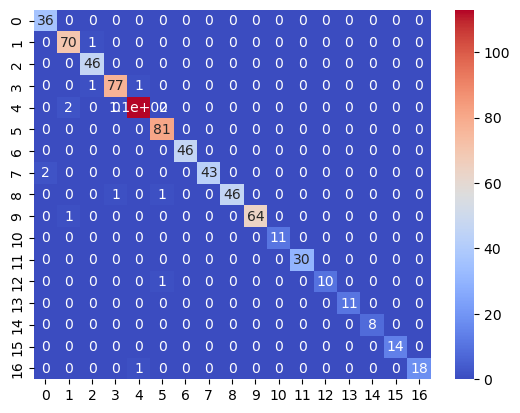

In [26]:
# Make predictions on the test data - pca 90
y_pred_rf_pca_95 = rf_model_pca_95.predict(age_x_valid_pca_95)

# get accuracy score
accuracy_score_rf_pca_95 = accuracy_score(
    age_y_valid_cat_encoded, y_pred_rf_pca_95)
print("accuracy_score_rf_pca_95_95: ", accuracy_score_rf_pca_95)
# Get confusion matrix
confusion_matrix_rf_pca_95 = confusion_matrix(
    age_y_valid_cat_encoded, y_pred_rf_pca_95)

# plot confusion matrix
sns.heatmap(confusion_matrix_rf_pca_95, annot=True, cmap="coolwarm")

# get precision, recall and f1 score
precision_recall_fscore_rf_pca_95 = precision_recall_fscore_support(
    age_y_valid_cat_encoded, y_pred_rf_pca_95, average="macro"
)
print("Precision, Recall and F1 Score:", precision_recall_fscore_rf_pca_95)


## Univariate Feature Selection


In [27]:
# Univariate feature selection
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=60)
selector.fit(age_x_train_cat, age_y_train_cat_encoded)

age_x_train_UFS = selector.transform(age_x_train_cat)
age_x_valid_UFS = selector.transform(age_x_valid_cat)
print("shape of X_train after UFS: ", age_x_train_UFS.shape)

selector_100 = SelectKBest(f_classif, k=100)
selector_100.fit(age_x_train_cat, age_y_train_cat_encoded)

age_x_train_UFS_100 = selector_100.transform(age_x_train_cat)
age_x_valid_UFS_100 = selector_100.transform(age_x_valid_cat)
print("shape of X_train after UFS: ", age_x_train_UFS_100.shape)


shape of X_train after UFS:  (28040, 60)
shape of X_train after UFS:  (28040, 100)


In [28]:
# Train a Random forest

rf_model_UFS = SVC()
rf_model_UFS.fit(age_x_train_UFS, age_y_train_cat_encoded)


SVC()

accuracy_score_rf_UFS:  0.9619565217391305
Precision, Recall and F1 Score: (0.9719114316848244, 0.9705893484193969, 0.9707390522447322, None)


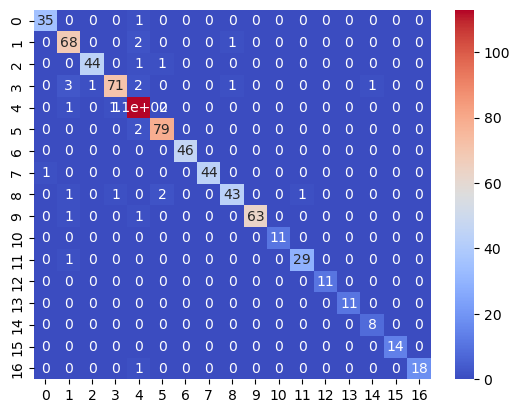

In [29]:
# Make predictions on the test data - UFS
y_pred_rf_UFS = rf_model_UFS.predict(age_x_valid_UFS)

# get accuracy score
accuracy_score_rf_UFS = accuracy_score(age_y_valid_cat_encoded, y_pred_rf_UFS)
print("accuracy_score_rf_UFS: ", accuracy_score_rf_UFS)
# Get confusion matrix
confusion_matrix_rf_UFS = confusion_matrix(
    age_y_valid_cat_encoded, y_pred_rf_UFS)

# plot confusion matrix
sns.heatmap(confusion_matrix_rf_UFS, annot=True, cmap="coolwarm")

# get precision, recall and f1 score
precision_recall_fscore_rf_UFS = precision_recall_fscore_support(
    age_y_valid_cat_encoded, y_pred_rf_UFS, average="macro"
)
print("Precision, Recall and F1 Score:", precision_recall_fscore_rf_UFS)


In [30]:
# Train a Random forest UFS 100

rf_model_UFS_100 = SVC()
rf_model_UFS_100.fit(age_x_train_UFS_100, age_y_train_cat_encoded)


SVC()

accuracy_score_rf_UFS_100:  0.9782608695652174
Precision, Recall and F1 Score: (0.985808902039287, 0.978217389837241, 0.9816884870287625, None)


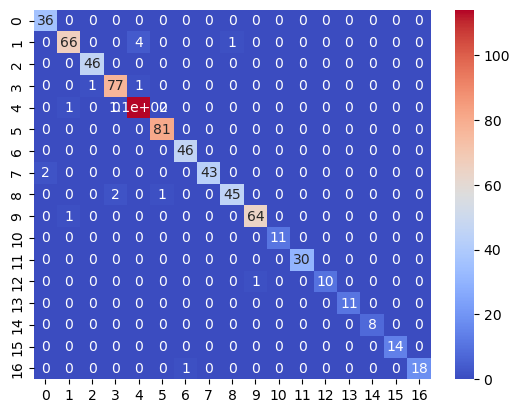

In [31]:
# Make predictions on the test data - UFS
y_pred_rf_UFS_100 = rf_model_UFS_100.predict(age_x_valid_UFS_100)

# get accuracy score
accuracy_score_rf_UFS_100 = accuracy_score(age_y_valid_cat_encoded, y_pred_rf_UFS_100)
print("accuracy_score_rf_UFS_100: ", accuracy_score_rf_UFS_100)
# Get confusion matrix
confusion_matrix_rf_UFS_100 = confusion_matrix(
    age_y_valid_cat_encoded, y_pred_rf_UFS_100
)

# plot confusion matrix
sns.heatmap(confusion_matrix_rf_UFS_100, annot=True, cmap="coolwarm")

# get precision, recall and f1 score
precision_recall_fscore_rf_UFS_100 = precision_recall_fscore_support(
    age_y_valid_cat_encoded, y_pred_rf_UFS_100, average="macro"
)
print("Precision, Recall and F1 Score:", precision_recall_fscore_rf_UFS_100)

## Correlation

Current best is age_x_train_pca_95


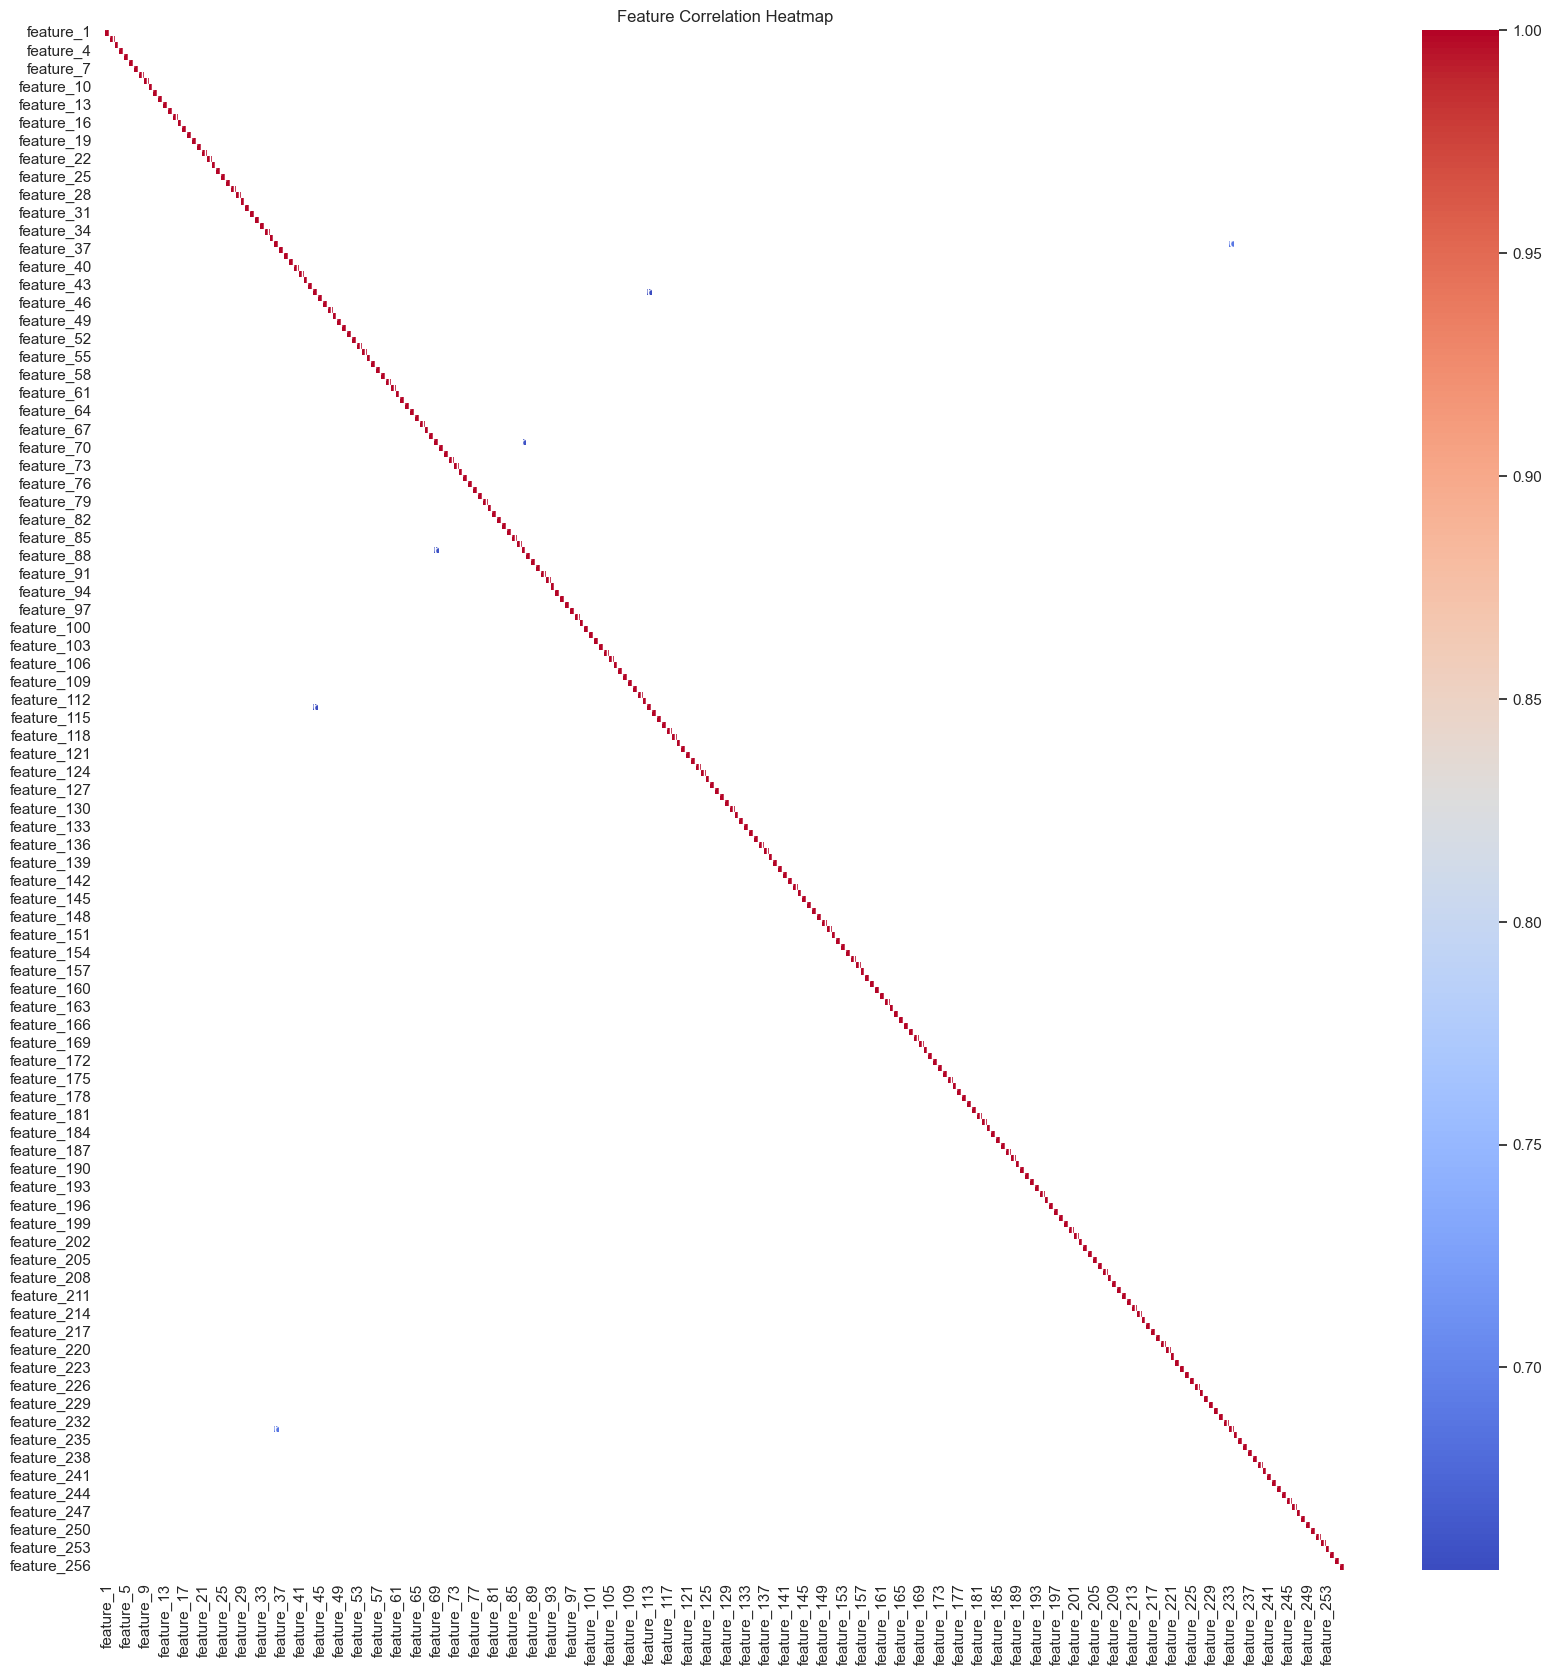

In [11]:
# plot correlation matrix
# concatenate the training data and the target variable -> To find the correlation with target variable
age_data_train_cat = pd.concat([age_x_train_cat, age_y_train_cat], axis=1)
correlation_matrix_age = age_data_train_cat.corr()

correlation_matrix = age_x_train_cat.corr()
filtered_correlation_matrix = correlation_matrix[correlation_matrix > 0.65]

sns.set(style="white")
plt.figure(figsize=(20, 20))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
# Find highly correlated features which have the least correlation with target variable
correlation_threshold = 0.65
highly_correlated = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            # Remove the feature with the least correlation with the target variable
            if abs(correlation_matrix_age.iloc[i, -1]) > abs(
                correlation_matrix_age.iloc[j, -1]
            ):
                colname = correlation_matrix.columns[j]
            else:
                colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)


In [13]:
highly_correlated

{'feature_113', 'feature_233', 'feature_69'}

In [18]:
# Remove highly correlated features from X_train
x_train_correlation = age_x_train_cat.copy()
x_valid_correlation = age_x_valid_cat.copy()
x_train_correlated_filtered = x_train_correlation.drop(
    columns=highly_correlated)
x_valid_correlated_filtered = x_valid_correlation.copy().drop(
    columns=highly_correlated)


In [19]:
# with 0.90
pca_cat_90_corr = PCA(n_components=0.95, svd_solver="full")

pca_cat_90_corr.fit(x_train_correlated_filtered)
n_components_90_corr = pca_cat_90_corr.components_.shape[0]


age_x_train_pca_90_corr = pd.DataFrame(
    pca_cat_90_corr.transform(x_train_correlated_filtered),
    columns=["feature_pca_" + str(i) for i in range(1, n_components_90_corr + 1)],
)
age_x_valid_pca_90_corr = pd.DataFrame(
    pca_cat_90_corr.transform(x_valid_correlated_filtered),
    columns=["feature_pca_" + str(i) for i in range(1, n_components_90_corr + 1)],
)

In [20]:
# Train a SVC on correlations removed PCA done data

rf_model_pca_90_corr = SVC()
rf_model_pca_90_corr.fit(age_x_train_pca_90_corr, age_y_train_cat_encoded)

SVC()

n_components_90_corr:  67
accuracy_score_rf_pca_90_corr_90_corr:  0.9864130434782609
Precision, Recall and F1 Score: (0.9904474312874714, 0.9832683906417269, 0.9865462292483732, None)


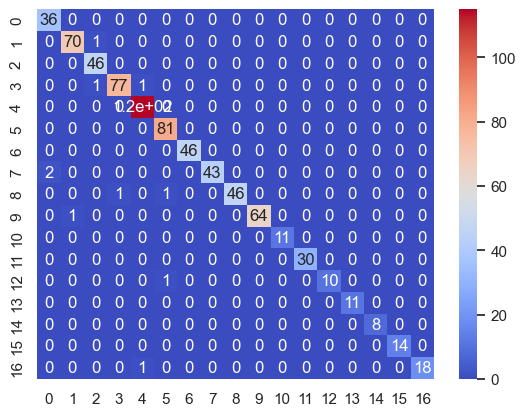

In [22]:
# Make predictions on the test data - pca 90
print("n_components_90_corr: ", n_components_90_corr)
y_pred_rf_pca_90_corr = rf_model_pca_90_corr.predict(age_x_valid_pca_90_corr)

# get accuracy score
accuracy_score_rf_pca_90_corr = accuracy_score(
    age_y_valid_cat_encoded, y_pred_rf_pca_90_corr
)
print("accuracy_score_rf_pca_90_corr_90_corr: ", accuracy_score_rf_pca_90_corr)
# Get confusion matrix
confusion_matrix_rf_pca_90_corr = confusion_matrix(
    age_y_valid_cat_encoded, y_pred_rf_pca_90_corr
)

# plot confusion matrix
sns.heatmap(confusion_matrix_rf_pca_90_corr, annot=True, cmap="coolwarm")

# get precision, recall and f1 score
precision_recall_fscore_rf_pca_90_corr = precision_recall_fscore_support(
    age_y_valid_cat_encoded, y_pred_rf_pca_90_corr, average="macro"
)
print("Precision, Recall and F1 Score:",
      precision_recall_fscore_rf_pca_90_corr)
